# TF-IDF -> PCA
# Sentence Transformer -> SVD
# Tuning: Setup -> Feature Extraction -> Hyperparameter Tuning
# Prediction: Setup -> Data Preprocessing (don't save new data) -> Deployment

# Setup

In [5]:
!pip install tqdm numpy gensim nltk pandas scipy==1.11.4
!pip install langdetect
# !pip install pickle
# !pip install pyvi
# !pip install tensorflow transformers
!pip install simpletransformers sentence_transformers fuzzy-c-means bertopic
# !pip install keras-tuner --upgrade
!pip install plotly orca

In [6]:
# import tensorflow as tf
# from tensorflow.python.client import device_lib
# from transformers import AutoModel, AutoTokenizer, BertTokenizer, BertModel
# import torch
import re, os, string
import pandas as pd
import numpy as np
import gensim
from gensim.models import Word2Vec
# from simpletransformers.classification import ClassificationModel
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from fcmeans import FCM
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
import pickle
import matplotlib.pyplot as plt
import plotly
import orca
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
from collections import Counter
import nltk
nltk.download('all')
from nltk import WordNetLemmatizer, ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from langdetect import detect
from sentence_transformers import SentenceTransformer
# from gradpyent.gradient import Gradients
from bertopic import BERTopic

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

In [7]:
from google.colab import drive, sheets
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
path_root = '/content/drive/MyDrive/Thailand Internship'

path_data_raw = '/content/drive/MyDrive/Thailand Internship/Data/Cyberbullying Youtube.csv'
path_data_cleaned = '/content/drive/MyDrive/Thailand Internship/Data/Cyberbullying Youtube Cleaned.csv'
path_word_raw = '/content/drive/MyDrive/Thailand Internship/Data/Cyberbullying Youtube Words.csv'

path_kmeans_model = '/content/drive/MyDrive/Thailand Internship/Model/kmeans_model.pkl'
path_fcm_model = '/content/drive/MyDrive/Thailand Internship/Model/spectral_model.pkl'
path_topic_model = '/content/drive/MyDrive/Thailand Internship/Model/topic_model.pkl'

path_kmeans_clustered = '/content/drive/MyDrive/Thailand Internship/Output/K-means Clustered.csv'
path_fcm_clustered = '/content/drive/MyDrive/Thailand Internship/Output/Fuzzy C-means Clustered.csv'
path_bertopic_clustered = '/content/drive/MyDrive/Thailand Internship/Output/Bert Topic Clustered.csv'

path_topic_labeled = '/content/drive/MyDrive/Thailand Internship/Output/Topic Labeled.csv'

path_visualization = '/content/drive/MyDrive/Thailand Internship/Visualization'

# Data Preprocesssing

In [ ]:
data_raw = pd.read_csv(path_data_raw)
data_raw.fillna(method ='ffill', inplace = True)

not_cyberbullying_sent = data_raw[data_raw['Type'] == 'not_cyberbullying']['Comment'].values[:1000]

gender_cyberbullying_sent = data_raw[data_raw['Type'] == 'gender']['Comment'].values[:1000] # lgbt
# age_cyberbullying_sent = data_raw[data_raw['Type'] == 'age']['Comment'].values[:1000]
religion_cyberbullying_sent = data_raw[data_raw['Type'] == 'religion']['Comment'].values[:1000] # muslim, islam, christian,...
ethnicity_cyberbullying_sent = data_raw[data_raw['Type'] == 'ethnicity']['Comment'].values[:1000] # racist, nigger,...
other_cyberbullying_sent = data_raw[data_raw['Type'] == 'other_cyberbullying']['Comment'].values[:1000]

list_comment_raw = np.concatenate((not_cyberbullying_sent,
                                   gender_cyberbullying_sent,
                                  #  age_cyberbullying_sent,
                                   religion_cyberbullying_sent,
                                   ethnicity_cyberbullying_sent,
                                   other_cyberbullying_sent),
                                  axis=0)

list_label_raw = np.concatenate((np.full(1000, 'not_cyberbullying'),
                             np.full(1000, 'gender'),
                             # np.full(1000, 'age'),
                             np.full(1000, 'religion'),
                             np.full(1000, 'ethnicity'),
                             np.full(1000, 'other_cyberbullying')))

print("Loaded",len(list_comment_raw),"comments from",path_data_raw)

Loaded 5000 comments from /content/drive/MyDrive/Thailand Internship/Data/Cyberbullying Youtube.csv


In [ ]:
def clean_text(text):
    # text = "".join(map(str, text))
    text = re.sub(r"http\S+", "", text) # remove link (r: raw string)
    text = re.sub(r"@\S+", "", text) # remove username
    text = re.sub(r"#\S+", "", text) # remove hashtag
    text = re.sub('<.*?>', '', text) # remove HTML tags and strip
    text = re.sub('(\s)+', r'\1', text) # consecutive spaces -> single space
    return text

def sentence_segment(text): # segment a multi-sentence comment
    sents = re.split("([.?!])?[\n]+|[.?!]", text)
    return sents

def normalize_text(text):
  if text == None:
    return

  for i in string.punctuation:
    text = text.replace(i, ' ')

  return re.sub('[^\w\s]', '', text).strip().lower() # remove special characters

In [ ]:
def word_segment(sent):
    words = word_tokenize(sent)
    return words

def remove_stopword(words):
    list_stop_words = set(stopwords.words('english'))
    filtered_words = []

    for w in words:
      if w not in list_stop_words:
          filtered_words.append(w)

    return filtered_words

def lemmatize(words):
  lemmatizer = WordNetLemmatizer()
  lemmatized_words = [lemmatizer.lemmatize(w) for w in words]

  return lemmatized_words

In [ ]:
def check_valid_sentence(sentence, testing=False):
  if not (sentence == None or sentence.strip().isdigit() or len(sentence.strip()) < 10):
    if detect(sentence) == 'en' or testing == True:
      return True
  return False

def check_valid_word(word):
  list_stop_words = set(stopwords.words('english'))
  return word not in list_stop_words

In [ ]:
def preprocess_data(list_comment_raw, list_label_raw=None, testing=False):
  list_comment_cleaned = []
  list_label_cleaned = []
  list_word_raw = []

  for i, comment in enumerate(list_comment_raw):
    sentences = sentence_segment(clean_text(comment))

    for sentence in sentences:
      normalized_sentence = normalize_text(sentence)

      if check_valid_sentence(normalized_sentence, testing):
        words = word_segment(normalized_sentence)

        filtered_words = remove_stopword(words)
        lemmatized_words = lemmatize(filtered_words)

        for word in lemmatized_words:
          if check_valid_word(word):
            list_word_raw = np.append(list_word_raw, word)

        cleaned_sentence = ' '.join(lemmatized_words)

        if cleaned_sentence not in list_comment_cleaned and check_valid_sentence(cleaned_sentence, testing):
          list_comment_cleaned = np.append(list_comment_cleaned, cleaned_sentence)
        if list_label_raw != None:
          list_label_cleaned = np.append(list_label_cleaned, list_label_raw[i])
    if(i%100==0):
        print("Preprocessed comments:", i, "/", len(list_comment_raw))

  # list_word_cleaned = list(set(list_word_raw))
  print("Preprocessed successfully!")

  if list_label_raw != None:
    return list_comment_cleaned, list_label_cleaned, list_word_raw

  return list_comment_cleaned, list_word_raw

In [ ]:
# list_comment_cleaned, list_label_cleaned, list_word_raw = preprocess_data(list_comment_raw, list_label_raw)

In [ ]:
# list_comment_cleaned, list_label_cleaned

In [ ]:
# dict_data_cleaned = {'Comment': list_comment_cleaned, 'Type': list_label_cleaned}
# df_data_cleaned = pd.DataFrame(dict_data_cleaned)
# df_data_cleaned.to_csv(path_data_cleaned, index=False)

In [ ]:
# list_word_raw[:10]

In [ ]:
# dict_word_raw = {'Word': list_word_raw}
# df_word_raw = pd.DataFrame(dict_word_raw)
# df_word_raw.to_csv(path_word_raw, index=False)

# Feature Extraction (Embedding)

In [ ]:
df_data_cleaned = pd.read_csv(path_data_cleaned)
list_comment_cleaned = df_data_cleaned['Comment'].values

In [ ]:
# # Vectorize words
# vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=5)
# E.g: max_df=50(times), min_df=0.1(%) - Ignore terms that appear in > 80% of document and < 5 times
# X = vectorizer.fit_transform(list_comment_cleaned).toarray()

In [ ]:
# # Embed sentences
sent_transformer = SentenceTransformer('paraphrase-MiniLM-L6-v2')
X = sent_transformer.encode(list_comment_cleaned).astype(np.float64)
X

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

array([[-9.35804844e-02, -9.07887146e-02, -3.46554965e-01, ...,
        -3.53453785e-01,  4.47478354e-01,  1.53543368e-01],
       [ 1.67771816e-01, -8.57472196e-02, -2.33976275e-01, ...,
        -2.33664840e-01,  4.46974665e-01, -8.10579479e-01],
       [-5.93956292e-01,  2.89831936e-01,  1.10289291e-01, ...,
         5.64223602e-02,  5.28780743e-02, -1.07082422e-03],
       ...,
       [-2.56874952e-02,  2.81915307e-01,  1.52232742e-03, ...,
         5.65276206e-01,  1.41510999e+00,  7.50170127e-02],
       [-5.94932139e-01, -5.85692376e-02,  1.57616451e-01, ...,
        -1.94123313e-01, -3.53915840e-01,  4.01663065e-01],
       [-6.89977169e-01,  7.91069210e-01,  6.45311847e-02, ...,
        -5.81205428e-01,  1.11859806e-01,  6.57215655e-01]])

In [ ]:
# # Load pre-trained BERT model and tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')

# def get_cls_sentence(sentence):
#     # Tokenize input sentence and convert to tensor
#     input_ids = torch.tensor([tokenizer.encode(sentence, add_special_tokens=True, max_length=512)])

#     # Pass input through BERT model and extract embeddings for [CLS] token
#     with torch.no_grad(): # don't update the gradient because this is not a training step
#         outputs = model(input_ids)
#         cls_embedding = outputs[0][:, 0, :]

#     return cls_embedding.flatten()

# X = [get_cls_sentence(sentence) for sentence in list_comment_cleaned]

# Dimensionality Reduction

In [ ]:
# pca = PCA(n_components=3)
# X_reduced = pca.fit_transform(X)

In [ ]:
svd = TruncatedSVD(n_components=3)
X_reduced = svd.fit_transform(X)

In [ ]:
# lda = LDA(n_components=3)
# X_reduced = lda.fit_transform(X, y)

# Data Visualization

In [ ]:
df_data_cleaned = pd.read_csv(path_data_cleaned)
list_comment_cleaned = df_data_cleaned['Comment'].values

list_sentence = [comment.split(' ') for comment in list_comment_cleaned]

df_word_raw = pd.read_csv(path_word_raw)
list_word_raw = df_word_raw['Word'].values

# window (int, optional) – Maximum distance between the current and predicted word within a sentence.
# min_count (int, optional) – Ignores all words with total frequency lower than this.
# sg ({0, 1}, optional) – Training algorithm: 1 for skip-gram; otherwise CBOW.
# workers - number of threads to train the model
# cbow_mean ({0, 1}, optional) – If 0, use the sum of the context word vectors. If 1, use the mean, only applies when cbow is used.
# negative (int, optional) – Number of negative sampling will be used (noise words) (usually between 5-20).
word2vec_model = Word2Vec(list_sentence, vector_size=100, window=5, min_count=2, sample=0.001, workers=4, negative=20, sg=0, cbow_mean=0, epochs=50)

tsne_model = TSNE(perplexity=5, n_components=3, init='pca', n_iter=2500, random_state=23) # perplexity = number of nearest neighbors

In [ ]:
def hex_to_RGB(hex_str):
    """#FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """Given two hex colors, returns a color gradient with n colors."""
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

In [ ]:
def visualize_word(df):
  specs = [[{'type': 'scatter3d'}, {'type': 'domain'}]] # specifications of subplot type, row/column spanning, and spacing.
  fig = sp.make_subplots(rows=1, cols=2, specs=specs, horizontal_spacing = 0.05,
                         subplot_titles=('Similarity, length and frequency of unigrams', 'Percentage of unigrams'))

  fig.add_trace(
    go.Scatter3d(
                x=df['x'],
                y=df['y'],
                z=df['z'],
                text=df['word'],
                hoverinfo='text',
                mode='text+markers',
                marker=dict(
                  size=df['frequency']/10,
                  color=df['length'],
                  colorscale='Cividis',
                  opacity=0.8,
                  colorbar=dict(
                      title='Length',
                      orientation='h',
                      y=-0.5,
                  )
                ),
    ),
    row=1, col=1,
  )

  fig.add_trace(
    go.Pie(values=df['frequency'],
           labels=df['word'],
           marker=dict(
              colors=get_color_gradient("#112D60", "#DD83E0", len(df['word']))
              ),
    ),
    row=1, col=2,
  )

  fig.update_layout(template='plotly_white')

  # fig.write_image(file=f"{path_visualization}/Word Visualization.png", format='.png', engine='kaleido')

  fig.show()

In [ ]:
# @title Word Visualization { run: "auto" }

n_words = 15 # @param {type:"slider", min:10, max:50, step:1}

word_freq = Counter(list_word_raw)
common_words = word_freq.most_common(n_words)
words, frequencies = zip(*common_words) # unzip
lengths = [len(w) for w in words]

tokens = np.array([word2vec_model.wv[word] for word in words])
embed_words = tsne_model.fit_transform(tokens)

df_word_cleaned = pd.DataFrame({
                    'word': words,
                    'frequency': frequencies,
                    'length': lengths,
                    'x': embed_words[:, 0],
                    'y': embed_words[:, 1],
                    'z': embed_words[:, 2],
                    })

visualize_word(df_word_cleaned)

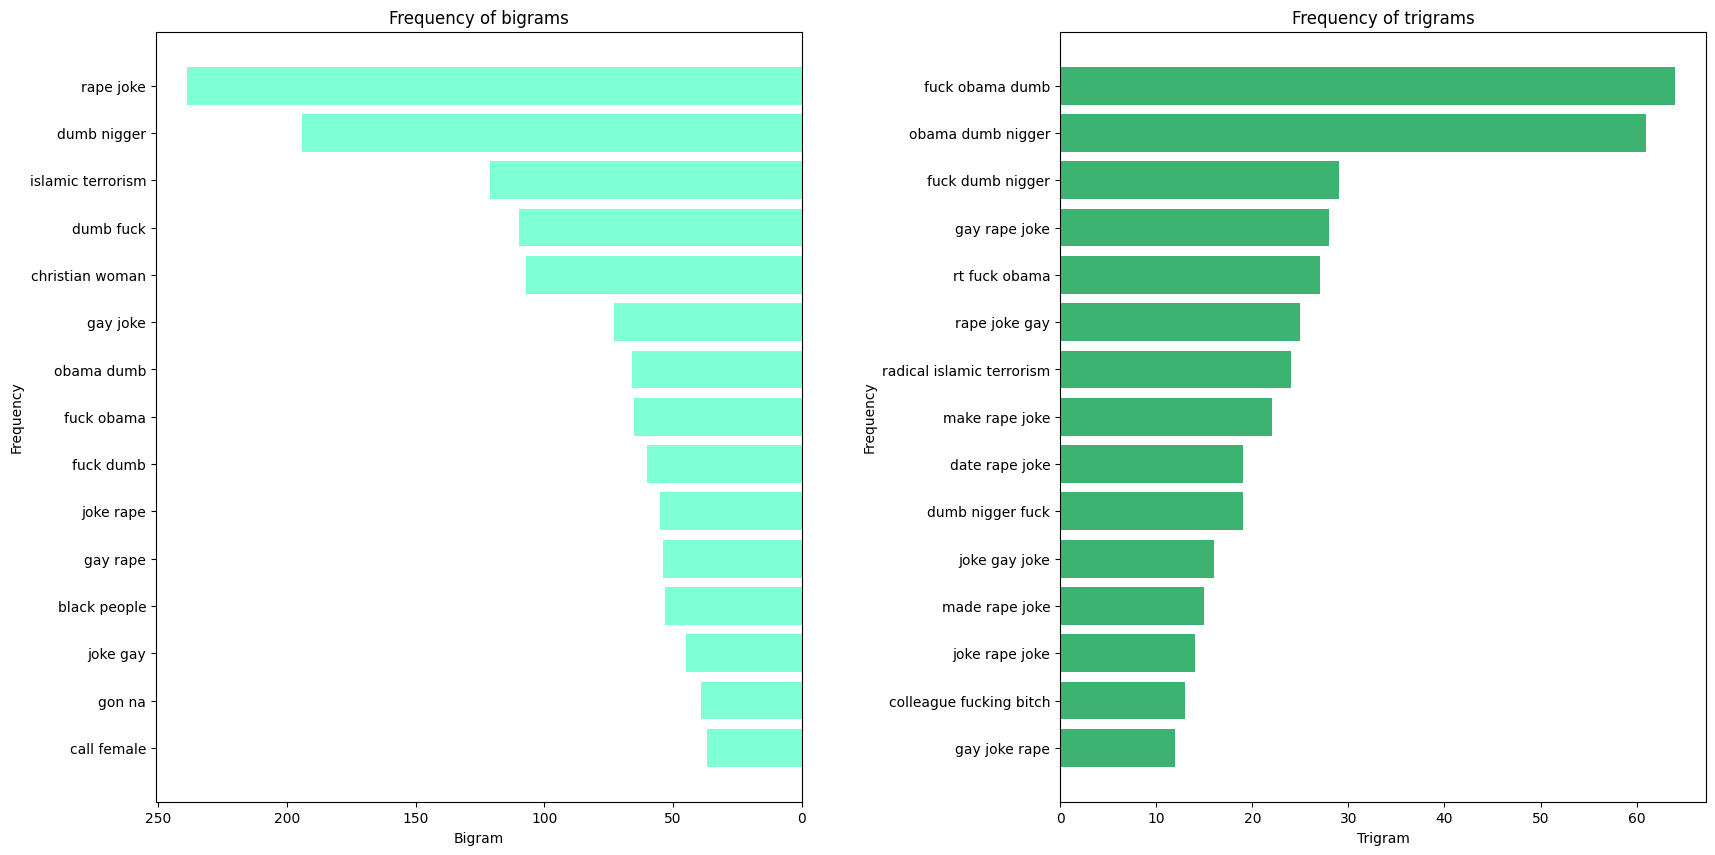

In [ ]:
# @title N-grams Visualization { run: "auto" }
n_words = 15 # @param {type:"slider", min:10, max:50, step:1}

bigram_list = list(ngrams(list_word_raw, 2)) # [('united', 'state'), ('state', 'cooked'),...]
bigram_list = [' '.join(bi) for bi in bigram_list]

bigram_counter = Counter(bigram_list)
bigrams, bi_freq = zip(*bigram_counter.most_common(n_words)) # unzip

trigram_list = list(ngrams(list_word_raw, 3))
trigram_list = [' '.join(tri) for tri in trigram_list]

trigram_counter = Counter(trigram_list)
trigrams, tri_freq = zip(*trigram_counter.most_common(n_words)) # unzip

# Bước 4: Tạo biểu đồ thanh
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(wspace=0.4,
                    hspace=0.4)

ax1 = fig.add_subplot(121)
ax1.barh(bigrams, bi_freq, color='aquamarine')
ax1.set_title('Frequency of bigrams')
ax1.set_xlabel('Bigram')
ax1.set_ylabel('Frequency')
ax1.invert_yaxis()  # Put the most common words at the top
ax1.invert_xaxis()

ax2 = fig.add_subplot(122)
ax2.barh(trigrams, tri_freq, color='mediumseagreen')
ax2.set_title('Frequency of trigrams')
ax2.set_xlabel('Trigram')
ax2.set_ylabel('Frequency')
ax2.invert_yaxis()  # Put the most common words at the top

plt.show()

# K-means

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans_clusters = kmeans.fit_predict(X)

In [ ]:
df_kmeans_clustered = pd.DataFrame(zip(list_comment_cleaned, kmeans_clusters), columns=['Comment', 'Cluster'])

for i in range(5):
  print(df_kmeans_clustered[df_kmeans_clustered['Cluster'] == i].head(10))

                                              Comment  Cluster
0                              word food crapilicious        0
2   p thanks head concerned another angry dude twi...        0
7                                      bully flush kd        0
12                love people call james potter bully        0
13                  officially hate stupid bus system        0
25                              probably worst though        0
29  thing uber even horrible sexist shitty company...        0
37                                fuck paper bullshit        0
42                     oh hey ashamed disgusting self        0
43    good news ever problem big mean bully know call        0
                                               Comment  Cluster
22                                         isolate one        1
63            even pickthall englishman muslim convert        1
68   walk circle around black meteor mecca delusion...        1
111  watched isi guy argue saudi muslim scholar twi

In [ ]:
# "other_cyberbullying", "religion", "not_cyberbullying", "ethnicity", "gender",

# Mapping labels from int -> string to compare
kmeans_mapping = []

for i in range(5):
  kmeans_mapping.append(input(f"Name the cluster {i}: "))

df_kmeans_clustered['Cluster'] = df_kmeans_clustered['Cluster'].map(lambda x: kmeans_mapping[int(x)])

Name the cluster 0: other_cyberbullying
Name the cluster 1: religion
Name the cluster 2: not_cyberbullying
Name the cluster 3: ethnicity
Name the cluster 4: gender


In [ ]:
# # Fuzzy C-Means is a fuzzy clustering method that groups clusters that do not have clear separation or contain too few data points into one
# fcm = FCM(n_clusters=5, m = 5) # m: fuzziness coefficient, higher m make clusters more clearly separated
# fcm.fit(X)
# fcm_clusters = fcm.predict(X)
# # fcm_clusters = 1 - fcm_clusters # swap labels 0 and 1: 1 - labels 1 = 0, 1 - labels 0 = 1

In [ ]:
# df_fcm_clustered = pd.DataFrame(zip(list_comment_cleaned, fcm_clusters), columns=['Comment', 'Cluster'])

# for i in range(5):
#   print(df_fcm_clustered[df_fcm_clustered['Cluster'] == i].head(10))

                                              Comment  Cluster
15  still jack amsterdam ciroc crown bud light lim...        0
16                     men one going push real change        0
18                              wishing arena partner        0
23                 know people like listen old school        0
24                                first time happened        0
35                  promo girl going bring next round        0
38                         charlie brown thanksgiving        0
59                             first social test year        0
60                                     start thursday        0
61                        class canceled tomorrow tho        0
                                                Comment  Cluster
834   like making joke rape survivor serial killer i...        1
839                            find offensively bigoted        1
919                   prison rape nothing homosexuality        1
936   abortion orphanage death illuminati cance

In [ ]:
# # "not_cyberbullying", "religion", "ethnicity", "gender", "other_cyberbullying",

# # Mapping labels from int -> string to compare
# fcm_mapping = []

# for i in range(5):
#   fcm_mapping.append(input(f"Name the cluster {i}: "))

# df_fcm_clustered['Cluster'] = df_fcm_clustered['Cluster'].map(lambda x: fcm_mapping[int(x)])
# df_fcm_clustered

Name the cluster 0: not_cyberbullying
Name the cluster 1: religion
Name the cluster 2: ethnicity
Name the cluster 3: gender
Name the cluster 4: other_cyberbullying


,Comment,Cluster
0,word food crapilicious,other_cyberbullying
1,classy whore,other_cyberbullying
2,p thanks head concerned another angry dude twi...,other_cyberbullying
3,isi account pretending kurdish account,ethnicity
4,yes test god good bad indifferent weird whatev...,ethnicity
...,...,...
5646,phone necessarily stored,ethnicity
5647,name would required,ethnicity
5648,let explain word problematic,other_cyberbullying
5649,everyone kept bullying tonight toe lolling co ...,other_cyberbullying


In [ ]:
pickle.dump(kmeans, open(path_kmeans_model, 'wb')) # write binary
# pickle.dump(fcm, open(path_fcm_model, 'wb')) # write binary

In [ ]:
df_kmeans_clustered.to_csv(path_kmeans_clustered, index=False)
# df_fcm_clustered.to_csv(path_fcm_clustered, index=False)

# Bert Topic

In [9]:
df_data_cleaned = pd.read_csv(path_data_cleaned)
list_comment_cleaned = df_data_cleaned['Comment'].values

In [33]:
# min_topic_size=50: keep only topics with sufficient number of documents
# nr_topics=7: merge topics by fixed number
topic_model = BERTopic(min_topic_size=50)
topics, probs = topic_model.fit_transform(list_comment_cleaned)

reduced_topics = topic_model.reduce_outliers(list_comment_cleaned, topics, strategy="embeddings") # c-tf-idf, embeddings, distributions
topic_model.update_topics(list_comment_cleaned, topics=reduced_topics)

2024-08-15 06:57:37,828 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [34]:
# Topic -1: Documents are not assigned to a specific topic.
# Count: number of do/cuments belonging to each topic.
# Name: Name of the topic
# Representation: Keywords that represent that topic.
# Representative_Docs: Documents that represent the topic.
df_raw_topic=topic_model.get_topic_info()
sheet = sheets.InteractiveSheet(df=df_raw_topic, title='Interactive Raw Topic Sheet')

https://docs.google.com/spreadsheets/d/1mNhaAvsnEKWVxmNb9TphABPAFqSVnmdTMNCpoSihh0c#gid=0


In [35]:
topic_model.visualize_hierarchy()

In [36]:
# topic_model.visualize_topics(custom_labels=True)
# topic_model.visualize_document_datamap(list_comment_cleaned)
topic_model.visualize_documents(list_comment_cleaned)

In [37]:
topics_to_merge = [[0, 4, 8,],
                   [1, 11],
                   [2, 5, 7,],
                   [6, 9, 13, 15, 16],
                   [3, 10, 12, 14],]
topic_model.merge_topics(list_comment_cleaned, topics_to_merge)

df_merged_topic=topic_model.get_topic_info()
df_merged_topic

,Topic,Count,Name,Representation,Representative_Docs
0,0,1483,0_muslim_christian_islamic_terrorist,"[muslim, christian, islamic, terrorist, terror...","[u know islamic terrorism, atia need correct s..."
1,1,1347,1_one_think_first_school,"[one, think, first, school, twitter, like, kno...","[know people like listen old school, ellie omg..."
2,2,984,2_rt_bully_amp_idiot,"[rt, bully, amp, idiot, bullying, fuck, fuckin...","[rt bitch stupid ððððð, rt right time, bully f..."
3,3,977,3_joke_rape_gay_woman,"[joke, rape, gay, woman, female, call, bitch, ...",[people make gay joke rape joke go away foreve...
4,4,860,4_nigger_dumb_fuck_black,"[nigger, dumb, fuck, black, white, as, people,...",[fuck obama dumb as nigger bitch shut yo white...


In [38]:
topic_model.visualize_barchart(top_n_topics=8, n_words=5)

In [39]:
topic_model.set_topic_labels({
                             -1: "outlier",
                              0: "religion",
                              1: "not_cyberbullying",
                              2: "other_cyberbullying",
                              3: "gender",
                              4: "ethnicity",
                            })

df_cleaned_topic=topic_model.get_topic_info()
df_cleaned_topic

,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,0,1483,0_muslim_christian_islamic_terrorist,religion,"[muslim, christian, islamic, terrorist, terror...","[u know islamic terrorism, atia need correct s..."
1,1,1347,1_one_think_first_school,not_cyberbullying,"[one, think, first, school, twitter, like, kno...","[know people like listen old school, ellie omg..."
2,2,984,2_rt_bully_amp_idiot,other_cyberbullying,"[rt, bully, amp, idiot, bullying, fuck, fuckin...","[rt bitch stupid ððððð, rt right time, bully f..."
3,3,977,3_joke_rape_gay_woman,gender,"[joke, rape, gay, woman, female, call, bitch, ...",[people make gay joke rape joke go away foreve...
4,4,860,4_nigger_dumb_fuck_black,ethnicity,"[nigger, dumb, fuck, black, white, as, people,...",[fuck obama dumb as nigger bitch shut yo white...


In [40]:
topic_model.save(path_topic_model, serialization="pickle")

2024-08-15 07:07:53,567 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [41]:
df_cleaned_topic.to_csv(path_topic_labeled, index=False)

In [42]:
document_info = topic_model.get_document_info(list_comment_cleaned)

df_bertopic_clustered = document_info[["Document", "CustomName"]]
df_bertopic_clustered = df_bertopic_clustered.rename(columns={"Document": "Comment", "CustomName": "Cluster"})

df_bertopic_clustered['Cluster'] = df_bertopic_clustered['Cluster'].replace("outlier", method='ffill').replace("outlier", method='bfill')

df_bertopic_clustered

,Comment,Cluster
0,word food crapilicious,not_cyberbullying
1,classy whore,gender
2,p thanks head concerned another angry dude twi...,not_cyberbullying
3,isi account pretending kurdish account,religion
4,yes test god good bad indifferent weird whatev...,religion
...,...,...
5646,phone necessarily stored,gender
5647,name would required,not_cyberbullying
5648,let explain word problematic,gender
5649,everyone kept bullying tonight toe lolling co ...,other_cyberbullying


In [43]:
df_bertopic_clustered.to_csv(path_bertopic_clustered, index=False)

# Evaluation

In [ ]:
def visualize_3d(title, X_reduced, clusters, centers):
  plt.figure(figsize=(10, 7))
  plt.title(title)

  ax = plt.axes(projection = "3d")
  p = ax.scatter3D(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=clusters, cmap='rainbow') # 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
  ax.set_xlabel("Principal Component 1")
  ax.set_ylabel("Principal Component 2")
  ax.set_zlabel("Principal Component 3")

  # Adding cluster centers to the plot
  centers_reduced = svd.transform(centers)
  ax.scatter3D(centers_reduced[:, 0], centers_reduced[:, 1], centers_reduced[:, 2], c='#FF6961', s=200, alpha=0.75, marker='*')

  # # Adding labels to the plot
  # for i, txt in enumerate(list_comment_cleaned):
  #     plt.annotate(txt, (X_reduced[i, 0], X_reduced[i, 1]), fontsize=9, alpha=0.75)

  plt.colorbar(p, label='Cluster Label')

  plt.show()

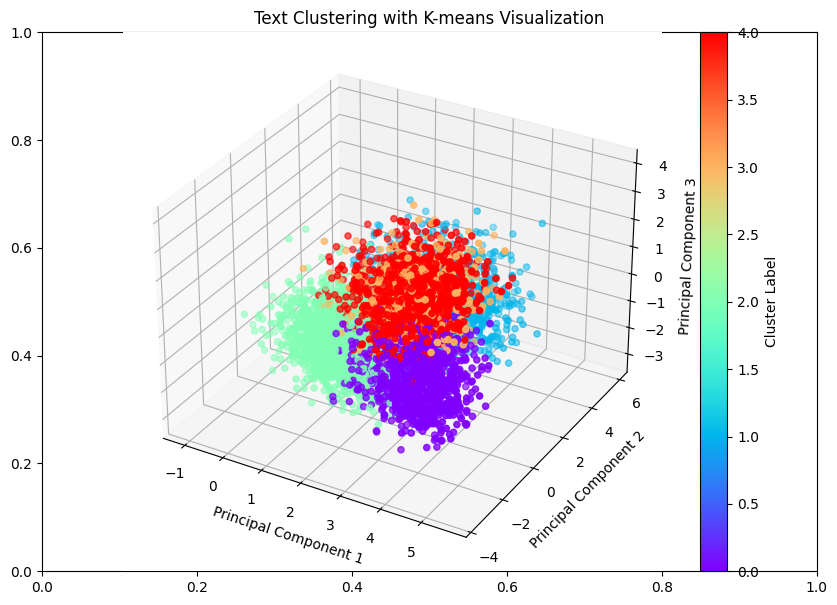

In [ ]:
kmeans_centers = kmeans.cluster_centers_
visualize_3d("Text Clustering with K-means Visualization", X_reduced, kmeans_clusters, kmeans_centers)

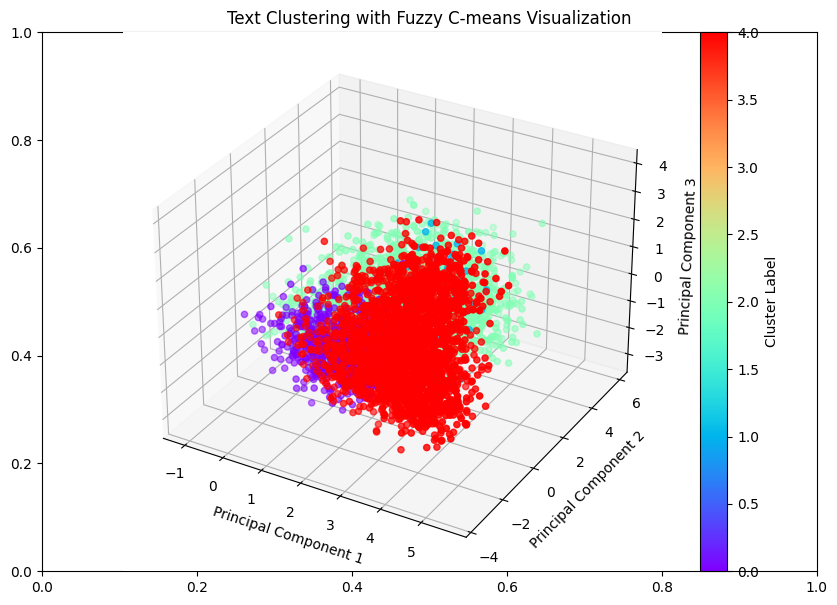

In [ ]:
# fcm_centers = fcm.centers
# visualize_3d("Text Clustering with Fuzzy C-means Visualization", X_reduced, fcm_clusters, fcm_centers)

In [44]:
topic_model.visualize_documents(list_comment_cleaned, custom_labels=True)

In [45]:
df_data_cleaned = pd.read_csv(path_data_cleaned)
clusteres_true = df_data_cleaned['Type'].values

df_kmeans_clustered = pd.read_csv(path_kmeans_clustered)
clusterers_kmeans = df_kmeans_clustered['Cluster'].values

# df_fcm_clustered = pd.read_csv(path_fcm_clustered)
# clusteres_fcm = df_fcm_clustered['Cluster'].values

df_bertopic_clustered = pd.read_csv(path_bertopic_clustered)
clusteres_bertopic = df_bertopic_clustered['Cluster'].values

In [46]:
acc_kmeans = accuracy_score(y_true=clusteres_true, y_pred=clusterers_kmeans)
f1_kmeans = f1_score(y_true=clusteres_true, y_pred=clusterers_kmeans, average='weighted')

# acc_fcm = accuracy_score(y_true=clusteres_true, y_pred=clusteres_fcm)
# f1_fcm = f1_score(y_true=clusteres_true, y_pred=clusteres_fcm, average='weighted')

acc_bertopic = accuracy_score(y_true=clusteres_true, y_pred=clusteres_bertopic)
f1_bertopic = f1_score(y_true=clusteres_true, y_pred=clusteres_bertopic, average='weighted')

print("K-means Accuracy:", acc_kmeans)
print("K-means F1 Score:", f1_kmeans)

# print("Fuzzy C-means Accuracy:", acc_fcm)
# print("Fuzzy C-means F1 Score:", f1_fcm)

print("Bert Topic Accuracy:", acc_bertopic)
print("Bert Topic F1 Score:", f1_bertopic)

K-means Accuracy: 0.48009201911166166
K-means F1 Score: 0.5108578384534663
Bert Topic Accuracy: 0.6133427711909396
Bert Topic F1 Score: 0.6401199225139842


# Hyperparameter Tuning

In [ ]:
# kmeans_sse = []
kmeans_scores = []
fcm_scores = []
bert_scores = []

n_clusters = np.arange(2, 21, 2, dtype=int).tolist()

In [ ]:
for i in n_clusters:
  kmeans = KMeans(n_clusters=i, n_init='auto')
  kmeans_clusters = kmeans.fit_predict(X)

  # Lower inertia indicates tighter and well-separated clusters
  # kmeans_sse.append(kmeans.inertia_)
  kmeans_scores.append(silhouette_score(X, kmeans_clusters))

# print('SSE of K-means =' , kmeans_sse)
print('Silhouette Score of K-means =', kmeans_scores)

Silhouette Score of K-means = [0.04489397453769526, 0.028972920860391677, 0.027913071791392706, 0.01993834805305606, 0.028177628387949, 0.021916683112243273, 0.024808284282612038, 0.022669607707526507, 0.021636508257401856, 0.021378311274214846]


In [ ]:
for i in n_clusters:
  fcm = FCM(n_clusters = i, m = 5)
  fcm.fit(X)
  fcm_clusters = fcm.predict(X) # swap labels 0 and 1: 1 - labels 1 = 0, 1 - labels 0 = 1

  fcm_scores.append(silhouette_score(X, fcm_clusters))

print('Silhouette Score of Fuzzy C-means =', fcm_scores)

Silhouette Score of Fuzzy C-means = [0.040866341493951665, 0.03178272501587214, 0.03284009136113707, -0.01549999928252672, -0.014018190130804747, -0.016438737611047527, -0.012833906862849166, -0.017134142892121215, -0.057582331515816675, -0.03627294337344622]


In [ ]:
for i in n_clusters:
  topic_model = BERTopic(nr_topics=i+1) # Example: i + 1 = 7 topics, 6 main topics and a topic (topic -1) refers to all outliers
  topics, probs = topic_model.fit_transform(list_comment_cleaned)

  bert_scores.append(silhouette_score(X, topics))

print('Silhouette Score of Bert Topic =', bert_scores)

Silhouette Score of Bert Topic = [0.008386998920776635, -0.02425108456516425, 0.006793321982582004, -0.018473711605874486, -0.013723463195670796, -0.019040835774449875, -0.018883888016706818, -0.015126961950341824, 0.003923208848799194, -0.010298007763811555]


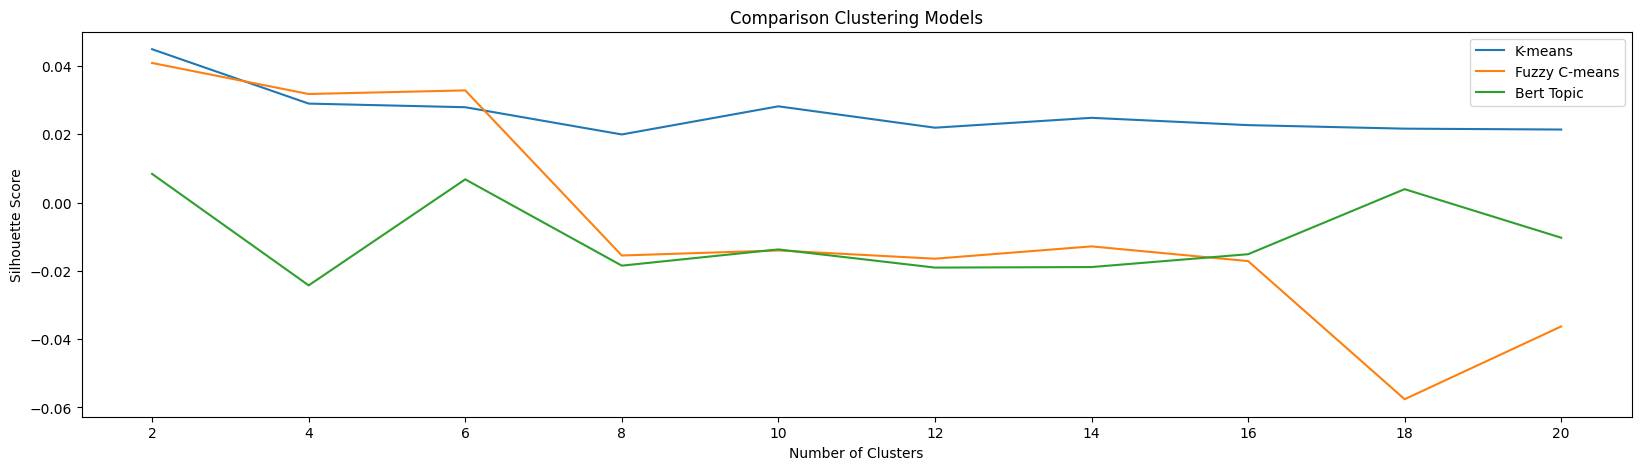

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(n_clusters, kmeans_scores, label = 'K-means')
plt.plot(n_clusters, fcm_scores, label = 'Fuzzy C-means')
plt.plot(n_clusters, bert_scores, label = 'Bert Topic')
plt.title('Comparison Clustering Models')
plt.xlabel('Number of Clusters')
plt.xticks(n_clusters)
plt.ylabel('Silhouette Score')
plt.legend()
plt.show()

# Deployment

In [ ]:
df_data_cleaned = pd.read_csv(path_data_cleaned)
list_comment_cleaned = df_data_cleaned['Comment'].values

sent_transformer = SentenceTransformer('paraphrase-MiniLM-L6-v2')

loaded_kmeans = pickle.load(open(path_kmeans_model, "rb")) # read binary
loaded_fcm = pickle.load(open(path_fcm_model, "rb")) # read binary
loaded_topic_model = BERTopic.load(path_topic_model)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
comment_predict = input("Input sentence to predict: ")
list_comment_predict, list_word_predict = preprocess_data(list_comment_raw = [comment_predict], testing = True)

# X_predict = sent_transformer.encode(np.concatenate((list_comment_cleaned, list_comment_predict),axis = 0)).astype(np.float64)
X_predict = sent_transformer.encode(list_comment_predict).astype(np.float64)

Input sentence to predict: Gays are perverts!
Preprocessed comments: 0 / 1
Preprocessed successfully!


In [ ]:
df_kmeans_clustered = pd.read_csv(path_kmeans_clustered)
idx2name_cluster = ["other_cyberbullying", "religion", "not_cyberbullying", "ethnicity", "gender"]

kmeans_predict = loaded_kmeans.predict([X_predict[-1]]) # X_predict[-1]: only predict new data, [X_predict[-1]]: input must be an array
cluster_predict = idx2name_cluster[kmeans_predict[0]]

print("K-means prediction: Topic", cluster_predict)
print("Representative docs:", ", ".join(df_kmeans_clustered[df_kmeans_clustered['Cluster'] == cluster_predict]['Comment'].values[:10]))

K-means prediction: Topic gender
Representative docs: classy whore, isso é bullying, look dc public school bullying lgbt student gone, let talk mean victim, noticed save witty reply sexist little panache, yeap breeding violence thing well, rt ceo sony europe vehemently unequivocally condemns misogynistic harassment, best martial art stopping bullying, evidence intentionally targeting child, minnesota gay teen bullied adult peer say activist reuters reuters barb schroeder knew


In [ ]:
predicted_topic = loaded_topic_model.transform([comment_predict])

print(f"Predicted topic: {predicted_topic[0][0]}, probability: {predicted_topic[1][0]}")
loaded_topic_model.get_topic_info(topic=predicted_topic[0][0])

Predicted topic: 2, probability: 0.5107321983729708


,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,2,763,2_joke_rape_gay_female,gender,"[joke, rape, gay, female, woman, call, bitch, ...","[straight gay men think rape joke funny, joke ..."
